In [2]:
#%matplotlib ipympl
import numpy as np
from numpy.fft import  ifft2, ifftshift
#from scipy.special import kv as beselk
from matplotlib import pyplot as plt
#from ipywidgets import interact, widgets
#from ows import ows

## PSD
Power spectrum density

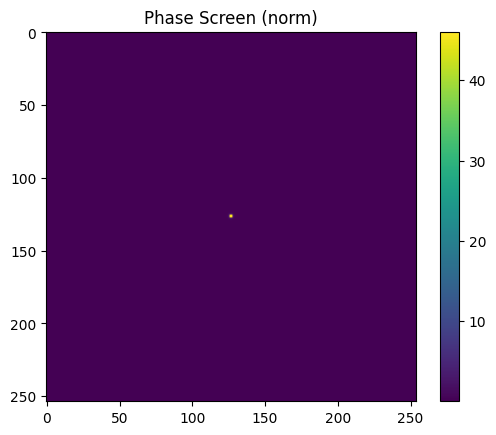

In [ ]:
def psdtemp(dim, r0, L0 = -1):
    """
    Generates a Phase power spectrum (PSD).

    Parameters:
    dim (int): Size of the phase screen matrix (must be even).
    dx (float): Pixel size in meters.
    r0 (float): Fried's parameter at 500 nm.
    outer_scale (float): Outer scale of turbulence (set to -1 for infinite scale).
    inner_scale (float): Inner scale of turbulence.
    seed (int, optional): Seed for random number generation.

    Returns:
    phase_screen (ndarray): 2D array representing the generated phase screen.
    """    


    # 2025.03.14 - Original version based on paola.pro (22.12.2022) by Laurent Jolissaint (HES-SO), lines 3659+
    # Not sure where all the coefficients come from
    #TODO: Make it work with L0 != -1
    #TODO: Change inherited variable names to something more meaningful


    # Prepare the x direction coordinate matrix
    x = np.linspace(-1, 1, dim).astype(np.double)#*dim/(2*dim)
    y = np.linspace(-1, 1, dim).astype(np.double)#*dim/(2*dim)
    fpcoohfx, fpcoohfy = np.meshgrid(x,y) # Since it will be computed anyways, fpcoohfy will be used instead of rotating the xmatrix.

    # Prepare the radius matrix
    xpcoohf = np.zeros((dim,dim))
    for i in range(dim):
        for j in range(dim):
            xpcoohf[i][j]= np.sqrt(fpcoohfx[i][j]**2 + fpcoohfy[i][j]**2)  # pupil plane coordianate radius

    fpcoohfx *=pupil_matrix_size # Scale the grid to the size of the pupil matrix
    fpcoohfy *=pupil_matrix_size # Scale the grid to the size of the pupil matrix
    xpcoohf *=pupil_matrix_size # Scale the grid to the size of the pupil matrix

    # Von Karman corrected PSD (L0 != -1) PAOLA:3666
    #Watm = np.zeros((dim,dim), dtype=np.double)
    if L0 == -1:
        #w = np.where(fpcoohf[0]**2+fpcoohf.T[0]**2 > 0)
        dphi = 6.883877*(xpcoohf/r0)**(5/3)
        Watm = 0.022896/(r0**(5/3))*np.sqrt(fpcoohfx**2+fpcoohfy**2)**(-11/3)
    else:
        w = np.where(xpcoohf != 0)
        dphi = 0.171661*(L0/r0)**(5/3)*((1.005635)-(2*np.pi*xpcoohf/L0))**(5/6)
                               #beselk(5/6,2*np.pi*xpcoohf/L0)
        #Original line:
        # if w[0] ne -1 then dphi[w] = 0.171661d*(double(L0)/r0LAM)^(5.d/3)*((1.005635d)-(2*!dpi*xpcoohf[w]/double(L0))^(5.d/6)*$beselk(2*!dpi*xpcoohf[w]/double(L0),5.d/6))
        Watm = 0.022896/(r0**(5/3))*(fpcoohfx**2+fpcoohfy**2 +1/(L0**2))**(-11/3)

    PSD = Watm*dphi
    return PSD

dim = 254  # Matrix size
pupil_matrix_size = 64
r0 = .1
L0 = -1

PSD = psdtemp(dim, r0, L0)

plt.close(0)
plt.figure(0)
plt.imshow((PSD))
plt.title("Phase Screen (norm)")
plt.colorbar()
plt.show()

## Phase screen

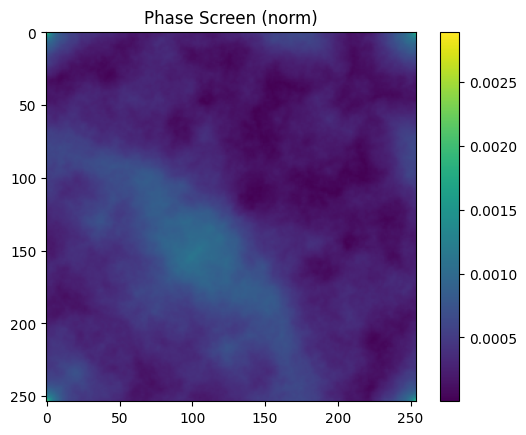

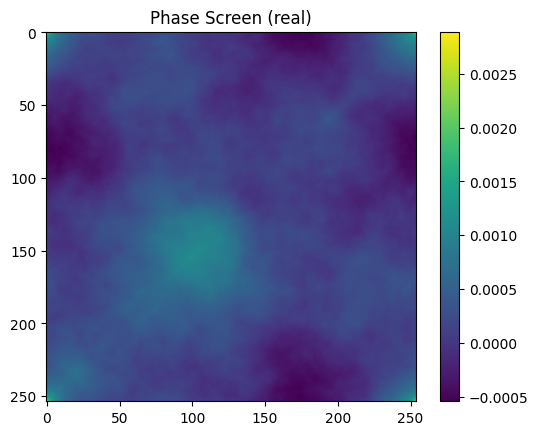

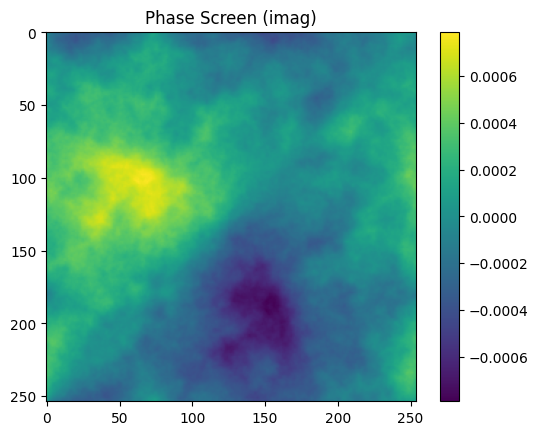

In [4]:
# Replace tmp1 and tmp2 to be more explicit
# They are currenty used in order to make it easier to compare with the original code
rad2asec = 3600 * 180/np.pi
asec2rad = 1/rad2asec

SEED = None
FoV = 60 # arcsec
Npx = 2000 # image plane pixels qty
Daf = asec2rad*FoV/Npx # [rad/px]
WL = 500e-9 # [m]

DFP = Daf/WL # [m^-1/px] Pupil plane spatial frequency pixel size
DXP = 1/(DFP*dim)

tmp2 = np.zeros((dim, dim)).astype(np.double)

tmp2[0 : dim, 0 : dim] = PSD * (dim * DXP) ** 2 #original IDL translated
#tmp2 = PSD*(dim*DXP)**2
#tmp2[0 : dim, dim-1] = tmp2[0 : dim, 0] # last row = 1st row
#tmp2[dim-1, 0 : dim] = tmp2[0, 0 : dim] # last column = 1st column
#tmp2[dim-1, dim-1] = tmp2[0, 0] # bottom right corner = top left corner

if SEED is not None:
  np.random.seed(SEED)
tmp2 = np.sqrt(tmp2) * np.random.rand(dim, dim)
tmp1 = np.sqrt(2) * (tmp2 + tmp2.T) / 2
tmp2 = np.random.rand(dim,dim) * 2 * np.pi
# in order to make sure that the phase is real,
# (1) the real part of the phase spectrum is forced to be even
# (2) the imaginary part of phase spectrum is forced to be odd
tmp2 =  (tmp1 * np.cos(0.5 * (tmp2 - tmp2.T)))[0 : dim, 0 : dim] +1j*(tmp1 * np.sin(0.5 * (tmp2 - tmp2.T)))[0 : dim, 0 : dim]
phaseft = tmp2
#phaseft -= np.mean(phaseft) # remove piston?
phase_screen = ifft2(ifftshift(phaseft))

plt.close(1)
plt.figure(1)
plt.imshow(np.abs(phase_screen))
plt.title("Phase Screen (norm)")
plt.colorbar()
plt.show()

plt.close(2)
plt.figure(2)
plt.imshow(np.real(phase_screen))
plt.title("Phase Screen (real)")
plt.colorbar()
plt.show()

plt.close(3)
plt.figure(3)
plt.imshow(np.imag(phase_screen))
plt.title("Phase Screen (imag)")
plt.colorbar()
plt.show()


